In [33]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [34]:
   !ls "/content/drive/My Drive/data-science-bowl-2018"

stage1_sample_submission.csv  stage2_sample_submission_final.csv
stage1_solution.csv	      stage2_test_final
stage1_test		      stage2_test_final.zip
stage1_test.zip		      stage_test_final_sa
stage1_train		      stage_test_sa
stage1_train_labels.csv       stage_train_sa
stage1_train.zip


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/drive/My Drive/data-science-bowl-2018/stage_train_sa/'
TEST_PATH = '/content/drive/My Drive/data-science-bowl-2018/stage_test_sa/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [37]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Resizing Completed')

Getting and resizing train images and masks ... 





  0%|          | 0/33 [00:00<?, ?it/s]


  6%|▌         | 2/33 [00:00<00:03, 10.24it/s]


 12%|█▏        | 4/33 [00:00<00:02, 11.78it/s]


 15%|█▌        | 5/33 [00:01<00:10,  2.65it/s]


 18%|█▊        | 6/33 [00:01<00:11,  2.30it/s]


 21%|██        | 7/33 [00:02<00:09,  2.81it/s]


 27%|██▋       | 9/33 [00:02<00:07,  3.13it/s]


 30%|███       | 10/33 [00:03<00:12,  1.79it/s]


 33%|███▎      | 11/33 [00:03<00:09,  2.33it/s]


 39%|███▉      | 13/33 [00:04<00:06,  2.89it/s]


 42%|████▏     | 14/33 [00:04<00:05,  3.49it/s]


 45%|████▌     | 15/33 [00:04<00:04,  3.81it/s]


 48%|████▊     | 16/33 [00:04<00:04,  4.01it/s]


 52%|█████▏    | 17/33 [00:05<00:04,  3.47it/s]


 55%|█████▍    | 18/33 [00:05<00:03,  3.91it/s]


 58%|█████▊    | 19/33 [00:08<00:14,  1.06s/it]


 61%|██████    | 20/33 [00:08<00:12,  1.02it/s]


 64%|██████▎   | 21/33 [00:09<00:08,  1.37it/s]


 67%|██████▋   | 22/33 [00:09<00:06,  1.79it/s]


 70%|██████▉   | 23/33 [00:09<00:04,  2.23it/s]


 73%|███████

Getting and resizing test images ... 





  0%|          | 0/29 [00:00<?, ?it/s]


 14%|█▍        | 4/29 [00:00<00:00, 35.61it/s]


 24%|██▍       | 7/29 [00:00<00:00, 30.03it/s]


 41%|████▏     | 12/29 [00:00<00:00, 33.93it/s]


 55%|█████▌    | 16/29 [00:00<00:00, 35.45it/s]


 69%|██████▉   | 20/29 [00:00<00:00, 36.28it/s]


 83%|████████▎ | 24/29 [00:00<00:00, 34.58it/s]


 97%|█████████▋| 28/29 [00:00<00:00, 35.55it/s]


100%|██████████| 29/29 [00:00<00:00, 35.40it/s]

Resizing Completed


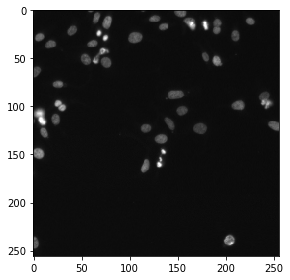

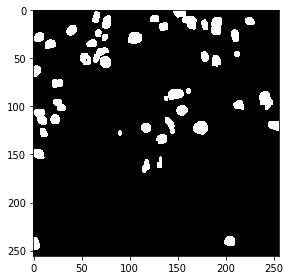

In [38]:
# Visualizing train image and masks
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Creating a function for Intersection of Union Metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [40]:
# Build U-Net model using keras
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [47]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model_unet_test.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=200, 
                    callbacks=[checkpointer])

Train on 29 samples, validate on 4 samples
Epoch 1/200
29/29 [==============================] - 1s 30ms/step - loss: 0.3517 - mean_iou: 0.4248 - val_loss: 0.5816 - val_mean_iou: 0.4259

Epoch 00001: val_loss improved from inf to 0.58162, saving model to model_unet_test.h5
Epoch 2/200
29/29 [==============================] - 1s 26ms/step - loss: 0.3384 - mean_iou: 0.4248 - val_loss: 0.5748 - val_mean_iou: 0.4258

Epoch 00002: val_loss improved from 0.58162 to 0.57477, saving model to model_unet_test.h5
Epoch 3/200
29/29 [==============================] - 1s 26ms/step - loss: 0.3332 - mean_iou: 0.4253 - val_loss: 0.5589 - val_mean_iou: 0.4257

Epoch 00003: val_loss improved from 0.57477 to 0.55894, saving model to model_unet_test.h5
Epoch 4/200
29/29 [==============================] - 1s 25ms/step - loss: 0.3164 - mean_iou: 0.4251 - val_loss: 0.5421 - val_mean_iou: 0.4256

Epoch 00004: val_loss improved from 0.55894 to 0.54213, saving model to model_unet_test.h5
Epoch 5/200
29/29 [======

In [48]:
# Predict on train, val and test and loading the saved model
model = load_model('model_unet_test.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

29/29 [==============================] - 0s 7ms/step


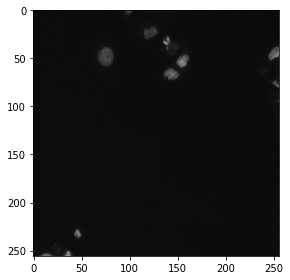

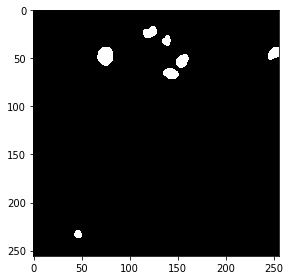

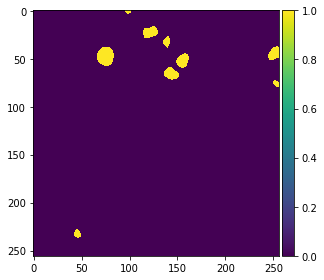

In [50]:
# Performing a sanity check on some random training samples
# the colored map is the predicted map
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

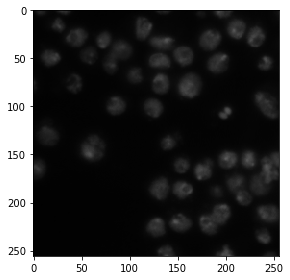

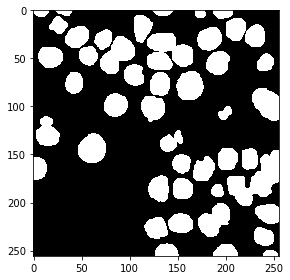

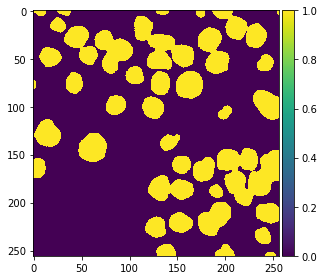

In [51]:
# Performing a sanity check on some random validation samples
# the colored map is the predicted map
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()